# Prepraration

In [0]:
# !pip install keras
# !pip install matplotlib
# !pip install tensorflow

In [0]:
# import tensorflow as tf

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12855983440330446032
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7814922172425082798
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10290762387392364676
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701463552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17304756826238518259
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [0]:
from tensorflow.python.keras import backend as K
 
import numpy as np
import matplotlib.pyplot as plt  
import os

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Phase 1 - Unsupervised Training

In [0]:
# Copy the rar file to local disk
%cd "/content/drive/My Drive/Colab Notebooks/Dataset/Dataset_Final_500/"
%cp -av real_train_500_2.rar /content/

/content/drive/My Drive/Colab Notebooks/Dataset/Dataset_Final_500
'real_train_500_2.rar' -> '/content/real_train_500_2.rar'


In [0]:
!unrar e real_train_500_2.rar /content/data/train/

In [0]:
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.optimizers import SGD

autoencoder = Sequential()

autoencoder.add(Conv2D(64, kernel_size=(11,11), strides=2, activation='relu', padding='valid', input_shape=(105,105,1)))
autoencoder.add(MaxPooling2D(pool_size=(2,2)))
autoencoder.add(Conv2D(128, kernel_size=(1,1), strides=1, activation='relu', padding='same'))

autoencoder.add(Conv2DTranspose(64, kernel_size=(1,1), strides=1, activation='relu', padding='same'))
autoencoder.add(UpSampling2D(size=(2,2)))
autoencoder.add(Conv2DTranspose(1, kernel_size=(11,11), strides=2, activation='relu', padding='valid'))


autoencoder.summary()

sgd = SGD(lr=0.01)
autoencoder.compile(optimizer=sgd , loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        7808      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       8320      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 24, 24, 64)        8256      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 105, 105, 1)       7745      
Total params: 32,129
Trainable params: 32,129
Non-trainable params: 0
____________________________________________________

In [0]:
train_dir = '/content/data/'

print(len(os.listdir(train_dir+"train/")))

1718754


In [0]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 128

train_datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.2)

training_generator = train_datagen.flow_from_directory(train_dir,
                                                     target_size=(105, 105),
                                                     color_mode='grayscale',
                                                     batch_size = batch_size,
                                                     class_mode='input',
                                                     subset='training',
                                                     shuffle=True)
validation_generator = train_datagen.flow_from_directory(train_dir,
                                                     target_size=(105, 105),
                                                     color_mode='grayscale',
                                                     batch_size = batch_size,
                                                     class_mode='input',
                                                     subset='validation',
                                                     shuffle=True)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:173: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 1375004 images belonging to 1 classes.
Found 343750 images belonging to 1 classes.


In [0]:
# def fixed_generator(generator):
#     for batch in generator:
#         yield (batch, batch)

In [0]:
import time

t1 = time.perf_counter()
history = autoencoder.fit_generator(generator=training_generator, 
                                    epochs=10, 
                                    steps_per_epoch=training_generator.samples // batch_size,
                                    validation_data=validation_generator,
                                    validation_steps = validation_generator.samples // batch_size,
                                    use_multiprocessing=True,
                                    shuffle=True)
t2 = time.perf_counter()
print(f"Finished in {round(t2 - t1, 2)} seconds")

Epoch 1/10
10742/10742 [==============================] - 913s 85ms/step - loss: 0.0119 - val_loss: 0.0087
Epoch 2/10
10742/10742 [==============================] - 918s 85ms/step - loss: 0.0057 - val_loss: 0.0069
Epoch 3/10
10742/10742 [==============================] - 947s 88ms/step - loss: 0.0043 - val_loss: 0.0055
Epoch 4/10
10742/10742 [==============================] - 952s 89ms/step - loss: 0.0036 - val_loss: 0.0051
Epoch 5/10
 6224/10742 [================>.............] - ETA: 5:20 - loss: 0.0033Buffered data was truncated after reaching the output size limit.

In [0]:
print(f"Finished in {round(t2 - t1, 2)} seconds")

Finished in 9499.96 seconds


In [0]:
import pickle

autoencoder_name = 'autoencoder_e10_3_SGD'

save_dir = '/content/drive/My Drive/Colab Notebooks/Model/'
autoencoder.save(save_dir+autoencoder_name+'.h5')

with open(save_dir+'/History/history_'+autoencoder_name, 'wb') as file_pi:
  pickle.dump(history.history, file_pi)


In [0]:
import gc

K.clear_session()
del autoencoder

gc.collect()

NameError: ignored

# Checking and plotting result

In [0]:
%cd "/content/drive/My Drive/Colab Notebooks/Dataset/Dataset_Final_500/"
%cp -av real_test.rar /content/

/content/drive/My Drive/Colab Notebooks/Dataset/Dataset_Final_500
'real_test.rar' -> '/content/real_test.rar'


In [0]:
!unrar e real_test.rar /content/test/


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from real_test.rar

Creating    /content/test                                             OK
Extracting  /content/test/1c5bdda44fe2f61683b4f67d107e9673a.8273.jpeg       2%  OK 
Extracting  /content/test/1c54c917a8e7166c77db81996770ad390.43097.jpeg       5%  OK 
Extracting  /content/test/1c55c4785c00718ea99d74e7539a5baa3.12314.png      10%  OK 
Extracting  /content/test/1c56fb828431e6562f0397901776c52a5.6650.jpeg      12%  OK 
Extracting  /content/test/1c57b505e2da2e75b6dcc3dc97b1550ae.66939.png      19%  OK 
Extracting  /content/test/1c545f9cbbc4e53b6b38368cccbed5dc0.44550.jpeg      22%  OK 
Extracting  /content/test/1c5363f98a78d7e5dc9dc753a4cf7425c.34585.png      28%  OK 
Extracting  /content/test/1c5371c12ae204a98b5241dde43a8453b.157125.png      36%  OK 
Extracting  /content/test/1c5441aef6b9dadbaea4735dfbdf5d2b4.33943.png      4

In [0]:
from tensorflow.python.keras.models import load_model

autoencoder_name = 'autoencoder_e10_SGD'
autoencoder_loaded = load_model(f'/content/drive/My Drive/Colab Notebooks/Model/{autoencoder_name}.h5')

In [0]:
autoencoder_loaded.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 64)        7808      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 128)       8320      
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 24, 24, 64)        8256      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 105, 105, 1)       7745      
Total params: 32,129
Trainable params: 32,129
Non-trainable params: 0
__________________________________________________

In [0]:
import cv2
import os

test_dir = '/content/test/'
x = []

for img in os.listdir(test_dir):
  x.append(cv2.resize(cv2.imread(test_dir+img, cv2.IMREAD_GRAYSCALE), (105,105)))

print(len(x))

22


In [0]:
import numpy as np

x = np.array(x)

x_test = x.astype('float32') / 255.
x_test = np.reshape(x_test, (len(x_test), 105, 105, 1))

In [0]:
from sklearn.model_selection import train_test_split
import gc


X_val = numpy[:1000]

del numpy
gc.collect()


0

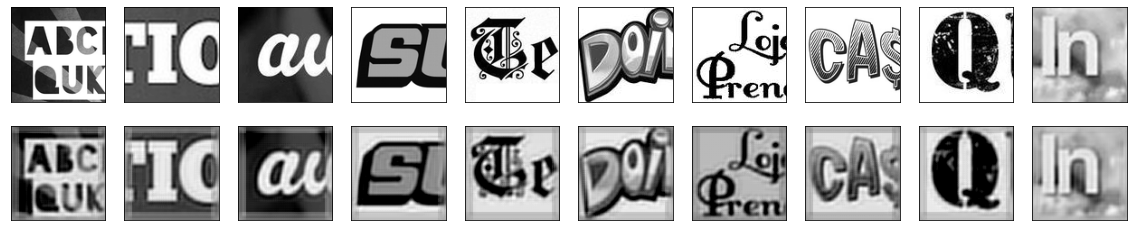

In [0]:
# X_val = np.reshape(X_val, (len(X_val), 105, 105, 1))
# X_val = X_val.astype('float32') / 255.
decoded_imgs = autoencoder_loaded.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i+10].reshape(105, 105))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n +1)
    plt.imshow(decoded_imgs[i+10].reshape(105, 105))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

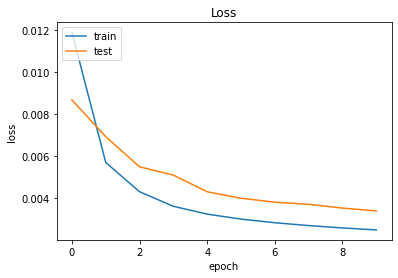

In [0]:
import pickle

save_dir = '/content/drive/My Drive/Colab Notebooks/Model/'
history_a = pickle.load(open(save_dir+'/History/history_'+autoencoder_name, 'rb'))

plt.plot(history_a['loss'])
plt.plot(history_a['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [0]:
print('Epoch ',len(history_a['loss']))
print(f"Last recorded loss : {history_a['loss'][-1]} val_loss : {history_a['val_loss'][-1]}")

Epoch  10
Last recorded loss : 0.002478950534715385 val_loss : 0.0033857285550637673


In [0]:
import gc

del autoencoder_loaded

gc.collect()

60115

In [0]:
import gc

del training_generator, validation_generator, train_datagen
del X_val
del autoencoder
K.clear_session()

gc.collect()

2793

# Autoencoder Example

In [0]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_example = Model(input_img, decoded)
autoencoder_example.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder_example.summary()

In [0]:
import gc

del autoencoder_example
gc.collect()

In [0]:
from keras.callbacks import TensorBoard

history= autoencoder_example.fit(x_train, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                )

In [0]:
decoded_imgs_2 = autoencoder_example.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n +1)
    plt.imshow(decoded_imgs_2[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
del decoded_imgs_2
gc.collect()

NameError: ignored

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# Phase 2 - Supervised Train

In [0]:
from tensorflow.python.keras import backend as K
 
import numpy as np
import matplotlib.pyplot as plt  
import os

In [0]:
%cd "/content/drive/My Drive/Colab Notebooks/Dataset/Dataset_Final_500/"
%cp -av syn_train_3.zip /content/

/content/drive/My Drive/Colab Notebooks/Dataset/Dataset_Final_500
'syn_train_3.zip' -> '/content/syn_train_3.zip'


In [0]:
!unzip -u -q /content/syn_train_3.zip -d /content/

print("Finished")

Finished


In [0]:
import os
import shutil

syn_path = '/content/syn_train/'

# Count total files
cpt = sum([len(files) for r, d, files in os.walk(syn_path)])
print(cpt)

1568521


In [0]:
# Loading autoencoder model

from tensorflow.python.keras.models import load_model

AE_DIR = '/content/drive/My Drive/Colab Notebooks/Model/autoencoder_e10_3_SGD.h5'
autoencoder = load_model(AE_DIR)

autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 64)        7808      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 24, 24, 64)        73792     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 105, 105, 1)       7745      
Total params: 163,201
Trainable params: 163,201
Non-trainable params: 0
________________________________________________

In [0]:
from tensorflow.python.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Flatten, Dropout
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.optimizers import SGD
# Create Cu and Cs layers

cnn = Sequential()

# Cu
cnn.add(Conv2D(64, kernel_size=(11,11), strides=2, activation='relu', padding='valid', input_shape=(105,105,1)))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))
cnn.add(Conv2D(128, kernel_size=(3,3), strides=1, activation='relu', padding='valid'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.layers[0].set_weights(autoencoder.layers[0].get_weights())
cnn.layers[3].set_weights(autoencoder.layers[2].get_weights())

cnn.layers[0].trainable = False
cnn.layers[3].trainable = False

# Cs
cnn.add(Conv2D(256, kernel_size=(3,3), strides=1, activation='relu', padding='same'))
cnn.add(Conv2D(256, kernel_size=(3,3), strides=1, activation='relu', padding='same'))
cnn.add(Conv2D(256, kernel_size=(3,3), strides=1, activation='relu', padding='same'))
cnn.add(Flatten())
cnn.add(Dense(4096, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(4096, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(500, activation='softmax'))

SGD = SGD(lr = 0.01, momentum = 0.9, decay = 0.0005)

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

lr_metric = get_lr_metric(SGD)

cnn.compile(optimizer=SGD, metrics=['accuracy', lr_metric, precision, recall], loss='sparse_categorical_crossentropy')

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 48, 48, 64)        7808      
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 128)       73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 22, 22, 128)       512       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 256)      

In [0]:
from tensorflow.python.keras.callbacks import ReduceLROnPlateau


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, mode='min', patience=1)

In [0]:
train_dir = '/content/syn_train/'

In [0]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 128

train_datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.2)

training_generator = train_datagen.flow_from_directory(train_dir,
                                                     target_size=(105, 105),
                                                     color_mode='grayscale',
                                                     batch_size = batch_size,
                                                     class_mode='sparse',
                                                     subset='training')
validation_generator = train_datagen.flow_from_directory(train_dir,
                                                     target_size=(105, 105),
                                                     color_mode='grayscale',
                                                     batch_size = batch_size,
                                                     class_mode='sparse',
                                                     subset='validation')

Found 1255021 images belonging to 500 classes.
Found 313500 images belonging to 500 classes.


In [0]:
import time

t1 = time.perf_counter()
history = cnn.fit_generator(generator=training_generator, 
                            epochs=10, 
                            steps_per_epoch=training_generator.samples // batch_size,
                            validation_data=validation_generator,
                            validation_steps = validation_generator.samples // batch_size,
                            use_multiprocessing=True,
                            callbacks=[reduce_lr]
                            )
t2 = time.perf_counter()
print(f"Finished in {round(t2 - t1, 2)} seconds")

Epoch 1/10
9804/9804 [==============================] - 638s 65ms/step - loss: 2.0275 - acc: 0.4614 - lr: 0.0100 - precision: 0.9584 - recall: 0.4468 - val_loss: 1.4441 - val_acc: 0.6051 - val_lr: 0.0100 - val_precision: 1.0000 - val_recall: 0.6623
Epoch 2/10
9804/9804 [==============================] - 616s 63ms/step - loss: 0.7693 - acc: 0.7321 - lr: 0.0100 - precision: 1.0000 - recall: 0.7836 - val_loss: 1.1138 - val_acc: 0.6910 - val_lr: 0.0100 - val_precision: 1.0000 - val_recall: 0.7735
Epoch 3/10
9804/9804 [==============================] - 616s 63ms/step - loss: 0.5813 - acc: 0.7891 - lr: 0.0100 - precision: 1.0000 - recall: 0.8498 - val_loss: 1.0291 - val_acc: 0.7133 - val_lr: 0.0100 - val_precision: 1.0000 - val_recall: 0.8103
Epoch 4/10
9804/9804 [==============================] - 614s 63ms/step - loss: 0.4948 - acc: 0.8164 - lr: 0.0100 - precision: 1.0000 - recall: 0.8792 - val_loss: 0.9725 - val_acc: 0.7290 - val_lr: 0.0100 - val_precision: 1.0000 - val_recall: 0.8275
Epoc

In [0]:
import pickle

cnn_name = 'DeepFont_5'

save_dir = '/content/drive/My Drive/Colab Notebooks/Model/'
cnn.save(save_dir+cnn_name+'.h5')

with open(save_dir+'/History/history_'+cnn_name, 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

In [0]:
# Saving the label map

import pickle
label_dict = (training_generator.class_indices)
print(label_dict)

with open(save_dir+'label_dict', 'wb') as file:
  pickle.dump(label_dict, file)

{'.New York': 0, '.New York Italic': 1, '007 GoldenEye': 2, 'AR JULIAN': 3, 'Adobe Arabic Bold': 4, 'Adobe Arabic Bold Italic': 5, 'Adobe Arabic Italic': 6, 'Adobe Arabic Regular': 7, 'Adobe Caslon Pro': 8, 'Adobe Caslon Pro Bold': 9, 'Adobe Caslon Pro Bold Italic': 10, 'Adobe Caslon Pro Italic': 11, 'Adobe Caslon Pro Semibold': 12, 'Adobe Caslon Pro Semibold Italic': 13, 'Adobe Fan Heiti Std B': 14, 'Adobe Fangsong Std R': 15, 'Adobe Garamond Pro': 16, 'Adobe Garamond Pro Bold': 17, 'Adobe Garamond Pro Bold Italic': 18, 'Adobe Garamond Pro Italic': 19, 'Aila': 20, 'Ailerons': 21, 'Arial': 22, 'Arial Black': 23, 'Arial Bold': 24, 'Arial Bold Italic': 25, 'Arial Italic': 26, 'Arial Narrow': 27, 'Arial Narrow Bold': 28, 'Arial Narrow Bold Italic': 29, 'Arial Narrow Italic': 30, 'Arial Rounded MT Bold': 31, 'Assassin$': 32, 'Athene': 33, 'Athletic Regular': 34, 'Augustus': 35, 'Battlestar': 36, 'Bebas': 37, 'Bebas Kai': 38, 'Bebas Neue': 39, 'Bell MT': 40, 'Bell MT Bold': 41, 'Bell MT Ita

In [0]:
import gc

del cnn
K.clear_session()

gc.collect()

33920

# Creating result graphs

In [0]:
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.optimizers import SGD

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

cnn_name = 'DeepFont_5'
cnn = load_model(f'/content/drive/My Drive/Colab Notebooks/Model/{cnn_name}.h5', custom_objects={'lr':get_lr_metric(SGD()), 'precision':precision, 'recall':recall})

In [0]:
print(K.eval(cnn_loaded.optimizer.lr))

0.01


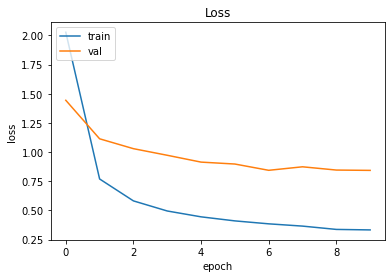

last recorded loss :  0.332424210307463
last recorded val_loss :  0.8429526225334774


In [0]:
import pickle

# cnn_name = 'DeepFont_3'
# save_dir = '/content/drive/My Drive/Colab Notebooks/Model/'
# history_a = pickle.load(open(save_dir+'/History/history_'+cnn_name, 'rb'))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

print('last recorded loss : ', history.history['loss'][-1])
print('last recorded val_loss : ', history.history['val_loss'][-1])

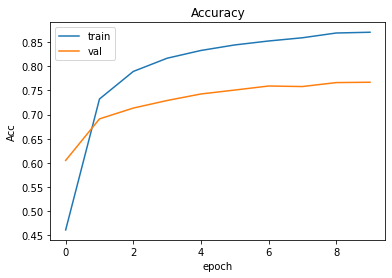

last recorded acc :  0.8700662
last recorded val_acc :  0.76672876


In [0]:
import pickle

save_dir = '/content/drive/My Drive/Colab Notebooks/Model/'
history_a = pickle.load(open(save_dir+'/History/history_'+cnn_name, 'rb'))

plt.plot(history_a['acc'])
plt.plot(history_a['val_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('Acc')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

print('last recorded acc : ', history_a['acc'][-1])
print('last recorded val_acc : ', history_a['val_acc'][-1])

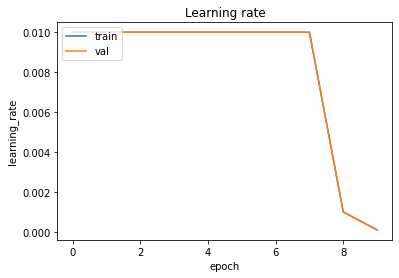

last recorded learning_rate :  9.999999e-05
last recorded val_lr :  0.00010000145


In [0]:
import pickle

# save_dir = '/content/drive/My Drive/Colab Notebooks/Model/'
# history_a = pickle.load(open(save_dir+'/History/history_'+cnn_name, 'rb'))

plt.plot(history.history['lr'])
plt.plot(history.history['val_lr'])
plt.title('Learning rate')
plt.xlabel('epoch')
plt.ylabel('learning_rate')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

print('last recorded learning_rate : ', history.history['lr'][-1])
print('last recorded val_lr : ', history.history['val_lr'][-1])

In [0]:
import gc

del cnn
K.clear_session()

gc.collect()

24184

# Model Evaluation

In [0]:
%cd "/content/drive/My Drive/Colab Notebooks/Dataset/Dataset_test/"
%cp -av Dataset_test_vfr.zip /content/

/content/drive/My Drive/Colab Notebooks/Dataset/Dataset_test
'Dataset_test_vfr.zip' -> '/content/Dataset_test_vfr.zip'


In [0]:
!unrar x dataset_test_50.rar /content/test/

In [0]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

batch_size = 128

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(test_data_path,
                                                  target_size=(105, 105),
                                                  batch_size=batch_size,
                                                  color_mode='grayscale',
                                                  class_mode='sparse',
                                                  shuffle=False)

Found 534 images belonging to 34 classes.


In [0]:
import pickle 

label_dict = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Model/label_dict', 'rb'))
font_dict = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Model/font_dict', 'rb'))

In [0]:
# function to return key for any value 
def get_label_name_from_key(val): 
    for key, value in label_dict.items(): 
      if val == value: 
        return key
    return "key doesn't exist"

get_key(499)

'Zurich Extended BT'

In [0]:
# evaluate the model
loss, accuracy, lr, precision, recall = cnn.evaluate_generator(test_generator, steps=test_generator.samples // batch_size + 1)

Instructions for updating:
Please use Model.evaluate, which supports generators.


In [0]:
print(f"loss : {loss}")
print(f"accuracy : {accuracy}")
print(f"precision : {precision}")
print(f"recall : {recall}")
print(f"lr : {lr}")

loss : 0.4247674345970154
accuracy : 0.8592245578765869
precision : 1.0
recall : 0.91764235496521
lr : 0.010000074282288551


In [0]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = cnn.predict_generator(test_generator, steps=test_generator.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
matrix = confusion_matrix(test_generator.classes, y_pred)
print(matrix)
print('Classification Report')
# report = classification_report(test_generator.classes, y_pred, output_dict=True)
print(classification_report(test_generator.classes, y_pred))

Confusion Matrix
[[0 0 0 ... 0 1 2]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      12.0
           1       0.00      0.00      0.00       4.0
           2       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       3.0
           4       0.00      0.00      0.00       4.0
           5       0.00      0.00      0.00       5.0
           6       0.00      0.00      0.00       4.0
           7       0.00      0.00      0.00       2.0
           8       0.00      0.00      0.00       2.0
           9       0.00      0.00      0.00       7.0
          10       0.00      0.00      0.00       6.0
          11       0.00      0.00      0.00       5.0
          12       0.00      0.00      0.00      35.0
          13       0.00      0.00      0.00     105.0
          14       0.00      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
from sklearn.metrics import precision_score , recall_score

precision_scr = precision_score(test_generator.classes,y_pred,average='weighted')
recall_scr = recall_score(test_generator.classes,y_pred,average='weighted')
print('avg precision : ', precision_scr)
print('avg recall : ', recall_scr)

avg precision :  0.8574584504192319
avg recall :  0.8592245343903244


In [0]:
import pickle

with open('/content/drive/My Drive/Colab Notebooks/Model/'+'matrix', 'wb') as file:
  pickle.dump(matrix, file)

In [0]:
import pickle
file_name = 'matrix_dataset_test_50'
matrix = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Model/'+file_name, 'rb'))

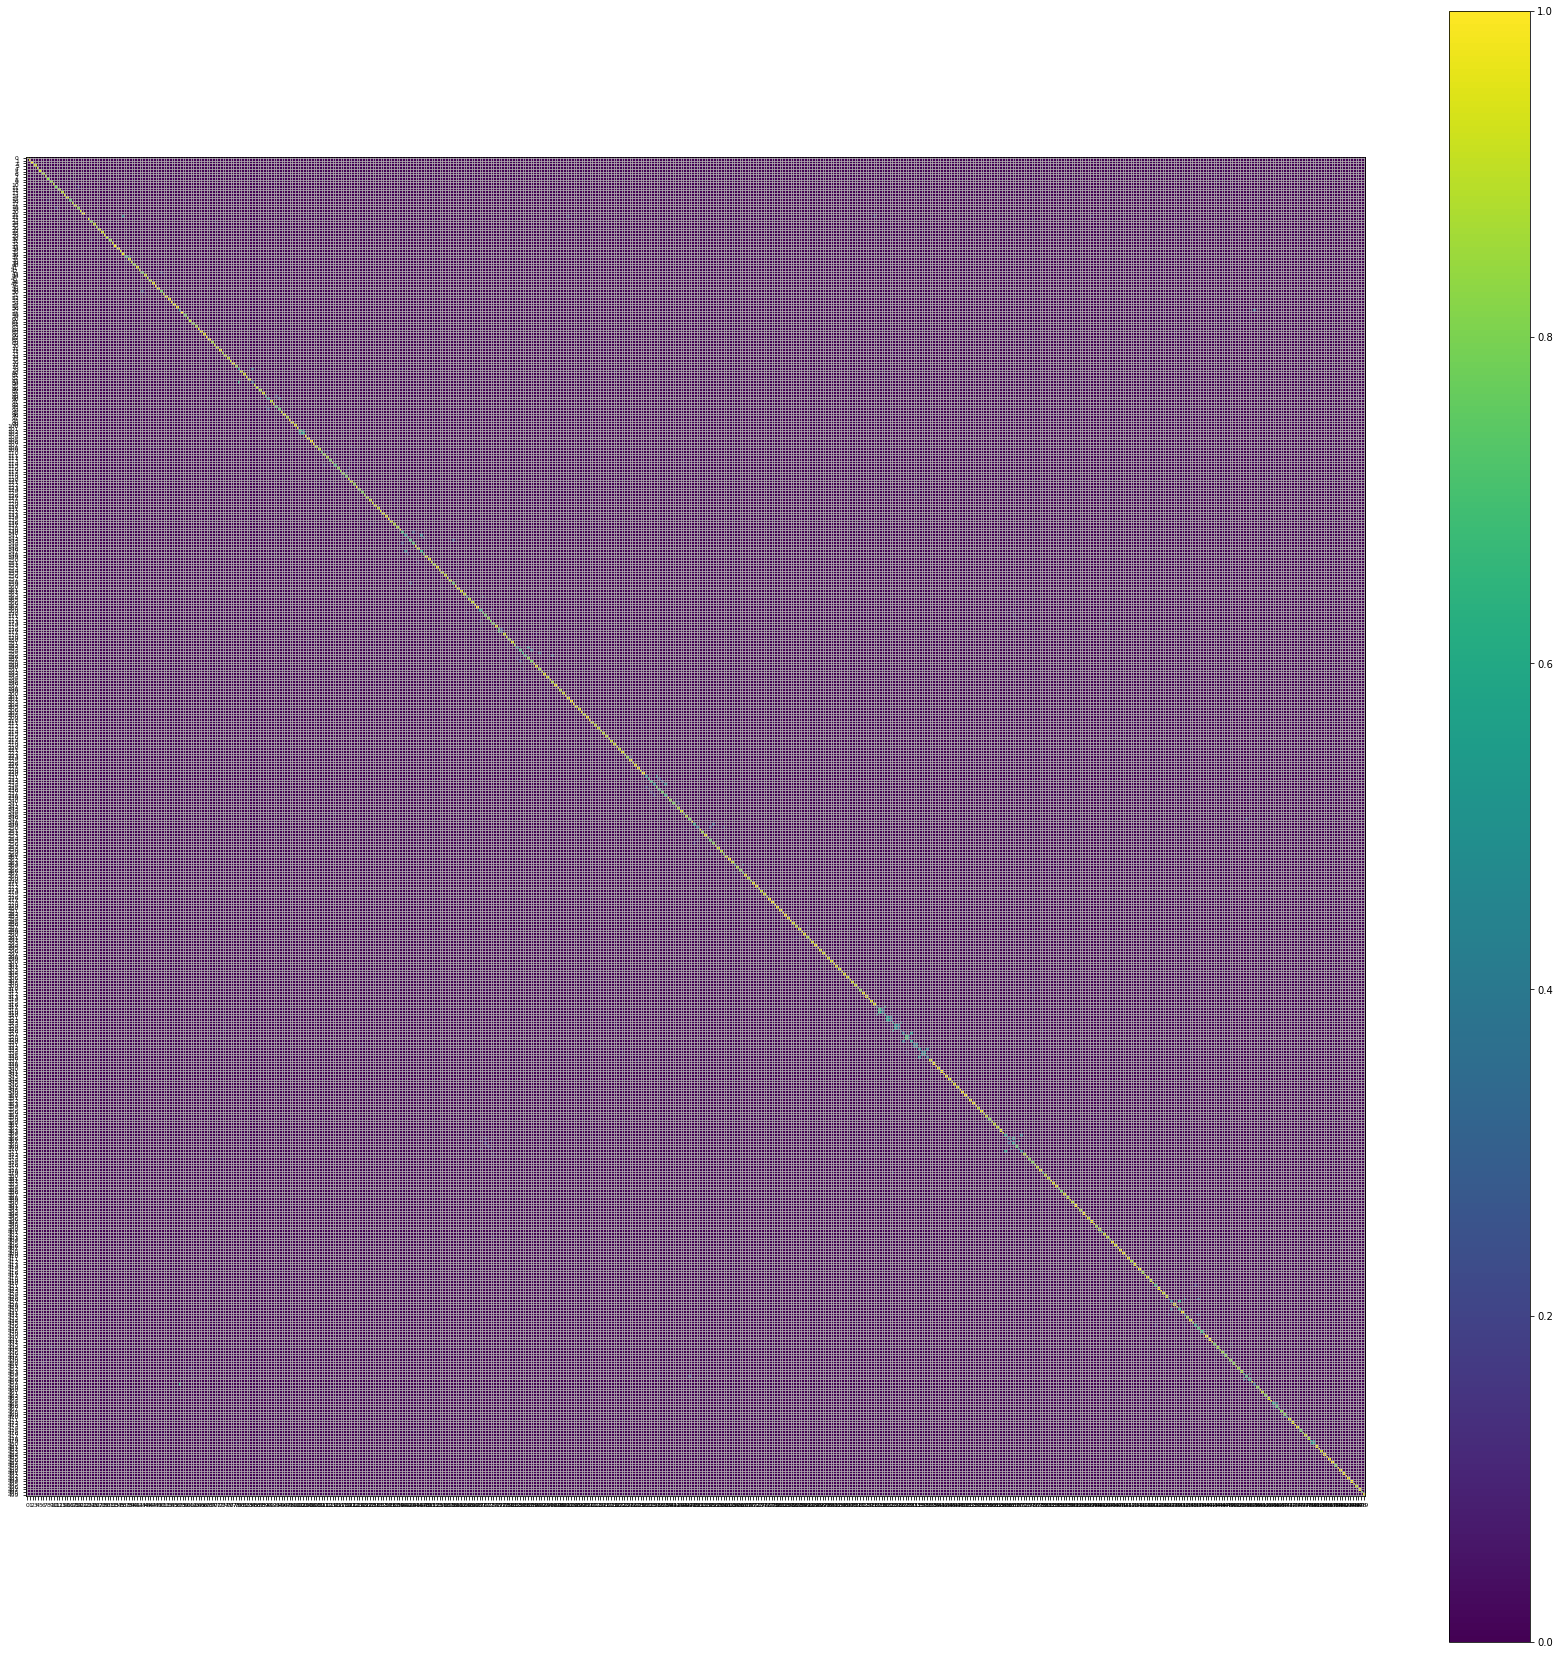

In [0]:
ticks=np.linspace(0, 499,num=500)
plt.figure(figsize=(30,30))
plt.imshow(cm, interpolation='none')
plt.colorbar()
plt.xticks(ticks,fontsize=6)
plt.yticks(ticks,fontsize=6)
plt.grid(True)
plt.show()

In [0]:
def get_key(val): 
  for key, value in label_dict.items(): 
    if int(val) == int(value): 
      return key

In [0]:
cm = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
print(cm)
acc = cm.diagonal()

[[0.93793103 0.         0.         ... 0.         0.         0.        ]
 [0.         0.91911765 0.         ... 0.         0.         0.        ]
 [0.         0.         0.99444444 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.96226415 0.         0.        ]
 [0.         0.         0.         ... 0.00740741 0.74074074 0.        ]
 [0.         0.         0.         ... 0.         0.         0.96      ]]


In [0]:
top5best = sorted( [(x,i) for (i,x) in enumerate(acc)], reverse=True )[:5]
print(top5best)
print([get_key(i) for x,i in top5best])

[(1.0, 492), (1.0, 278), (1.0, 168), (1.0, 58), (0.9970059880239521, 487)]
["Wolf's Bane Outline", "Grendel's Mother", 'Gill Sans MT Ext Condensed Bold', 'Bombing', 'VTCBelialsBladeTricked']


In [0]:
top5worst = sorted( [(x,i) for (i,x) in enumerate(acc)], reverse=True )[-5:]
print(top5worst)
print([get_key(i) for x,i in top5worst])

[(0.265, 177), (0.2535211267605634, 426), (0.23841059602649006, 329), (0.23357664233576642, 326), (0.0, 22)]
['Gill Sans Ultra Bold', 'Lucida Grande', 'HK Grotesk Medium Italic Legacy', 'HK Grotesk Light Legacy', 'Arial']


# Visualize VFR Test

In [0]:
%cd "/content/drive/My Drive/Colab Notebooks/Dataset/Dataset_test/"
%cp -av Dataset_test_vfr.zip /content/

In [0]:
from imutils import paths
import random

test_data_path = "/content/Dataset_test_vfr/"
data=[]
labels=[]
imagePaths = sorted(list(paths.list_images(test_data_path)))
print(len(imagePaths))

534


In [0]:
!unzip -u -q /content/Dataset_test_vfr.zip -d /content/

print("Finished")

Finished


In [0]:
import cv2
import os

X = []
y = []

def get_label_idx(label):
  return label_dict[label]

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

def crop_image(img, size):
  pos_x = 0
  pos_y = 0
  offset_x = 0
  n = img.shape[1] // 105
  result_img = []
  for i in range(n):
    crop_img = img[pos_y:pos_y+size, pos_x+offset_x:pos_x+offset_x+size].copy()
    result_img.append(crop_img)
    offset_x += size
  return result_img
  # for img in result_img:
  #   plt.figure()
  #   plt.imshow(img)
  # plt.show()


for imagePath in imagePaths:
  label = imagePath.split(os.path.sep)[-2]
  img = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
  img = image_resize(img, height = 105)
  rst = crop_image(img, 105)
  for img in rst:
    X.append(img)
    y.append(get_label_idx(label))

print(np.array(X).reshape(-1, 105, 105, 1).shape)
print(len(y))

(3505, 105, 105, 1)
3505


In [0]:
X = np.array(X).reshape(-1, 105, 105, 1)
X = X / 255.
y = np.array(y)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = cnn.predict(X)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(y, y_pred))
print('Classification Report')
print(classification_report(y, y_pred))

Confusion Matrix
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.70      0.06      0.12       111
           9       0.00      0.00      0.00        23
          10       0.00      0.00      0.00         3
          11       0.50      0.13      0.21        30
          12       0.00      0.00      0.00        26
          13       0.56      0.32      0.41        31
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00        32
          17       0.00      0.00      0.00         0
          18       0.16      0.12      0.14        25
          19       0.00      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Result 1 :  ['Chaparral Pro Bold Italic', 'Gotham Ultra']
Result 2 :  99
# Chaparral Pro Bold Italic
# ChaparralPro-BoldIt.otf
Result 1 :  ['Adobe Garamond Pro Bold', 'Perpetua Titling MT Bold', 'Minion Pro Bold', 'VTCBelialsBladeItalic']
Result 2 :  17
# Adobe Garamond Pro Bold
# AGaramondPro-Bold.otf
Result 1 :  ['Han Solo Expanded Laser', 'Good VibesBackbeat', 'InvisibleKiller', 'VTCBelialsBladeShadow']
Result 2 :  204
# Good VibesBackbeat
# Good VibesBackbeat.ttf
Result 1 :  ['Goudy Stout', 'InvisibleKiller', 'InvisibleKiller', 'InvisibleKiller', 'Battlestar', 'VTCBelialsBlade Regular', 'InvisibleKiller', 'Athletic Regular', 'InvisibleKiller', 'Goudy Stout']
Result 2 :  391
# InvisibleKiller
# invisibl.ttf
Result 1 :  ['JANUARY', 'Lucida Bright', 'Adobe Garamond Pro', 'Sitka Banner', 'Sitka Banner', 'Lucida Bright']
Result 2 :  416
# Lucida Bright
# LBRITE.TTF
/content/drive/My Drive/Colab Notebooks/Fonts_500/ChaparralPro-BoldIt.otf
/content/drive/My Drive/Colab Notebooks/Fonts_500

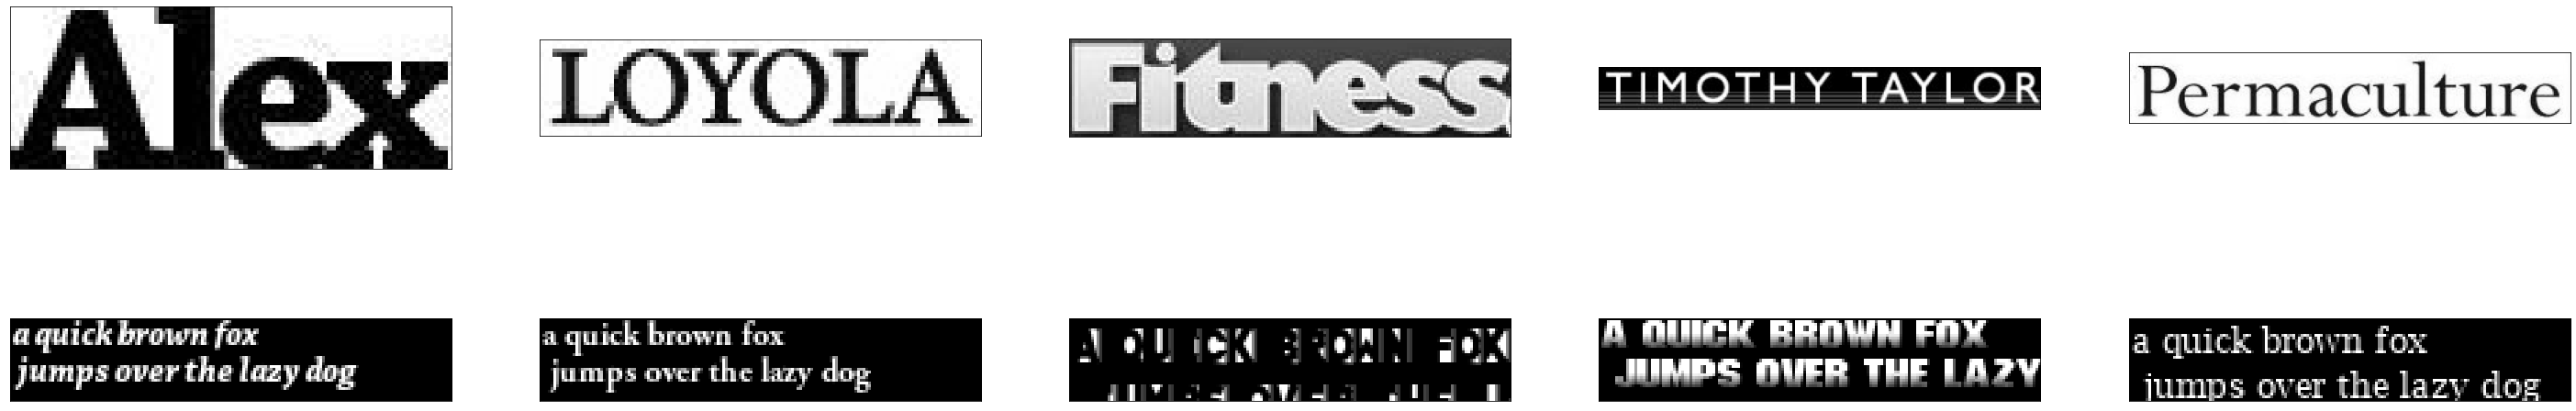

In [0]:
from PIL import Image, ImageDraw, ImageFont
import random
def drawFontSample(fontfile):
  img = Image.new('RGB', (160, 30), color = (0, 0, 0))
  print(f"/content/drive/My Drive/Colab Notebooks/Fonts_500/{fontfile}")
  fnt = ImageFont.truetype(f'/content/drive/My Drive/Colab Notebooks/Fonts_500/{fontfile}', 12)
  d = ImageDraw.Draw(img)
  d.text((1,1), "a quick brown fox\n jumps over the lazy dog", font=fnt, fill=(255, 255, 255))
  return img

def predict_single(imgPath):
  img = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
  img = image_resize(img, height = 105)
  rst = crop_image(img, 105)
  rst = np.array(rst).reshape(-1, 105, 105, 1)
  rst = rst / 255.
  # Predict
  result = cnn.predict_classes(rst)
  print("Result 1 : ", [get_label_name_from_key(item) for item in result ])
  #Result
  result = np.bincount(result).argmax()
  print("Result 2 : ", result)
  # Convert it to label name
  label = get_label_name_from_key(result)
  print("#",label)
  print("#",font_dict[label])
  return font_dict[label]

ori = []
predicted = []
imagePaths_2 = imagePaths
random.shuffle(imagePaths_2)
for imagePath in imagePaths_2[:5]:
  label = imagePath.split(os.path.sep)[-2]
  ori.append(cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE))
  predicted.append(predict_single(imagePath))

n = 5
plt.figure(figsize=(50, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(ori[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(drawFontSample(predicted[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()